In [67]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft
import sounddevice as sd
from scipy.signal import hann
from scipy.fft import ifft
from scipy.fft import fftshift
import scipy

### 1. Frequency modulation sound synthesis (0.5 points)

In [68]:
fs = 16000   # Sampling rate
fc = 880     # Carrier frequency
fmod = 220   # Modulation frequency
amplitude = 1
I = 2        # Modulation index
duration = 1 # number of samples in signal

#### Create the signal, plot it and also its DFT spetrum

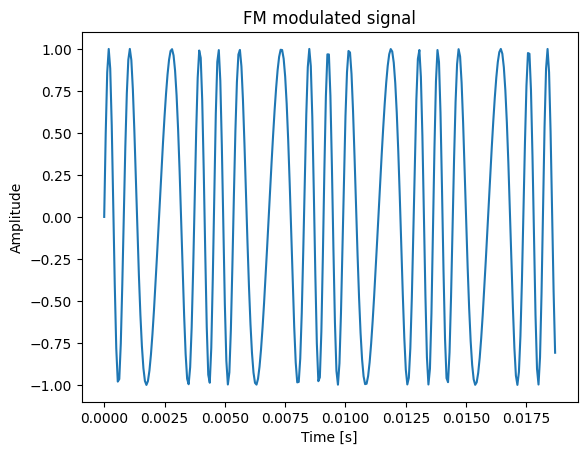

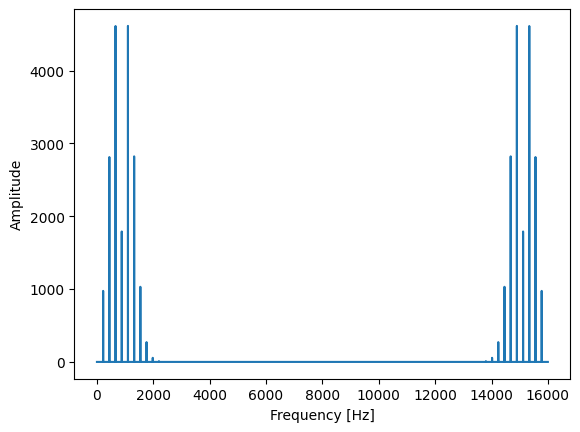

In [69]:
# The FM modulated signal
plt.title('FM modulated signal')
t = np.arange(0, duration, 1/fs)
y= amplitude*np.sin(2*np.pi*fc*t+I*np.sin(2*np.pi*fmod*t))


# Plot
plot = plt.plot(t[:300], y[:300])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
# Compute DFT and plot it
DFT = np.abs(fft(y))
plt.plot(DFT)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.show()

#### Play the sound

In [70]:
sd.play(y, fs)
sd.wait()

#### Auxiliary functions

In [71]:
def princarg(phase_in):
    """
    Computes principle argument,  wraps phase to (-pi, pi]
    """
    phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
    return phase
  

def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi

### 2. Implement a time stretching algorithm using phase vocoder. (1.5 points)

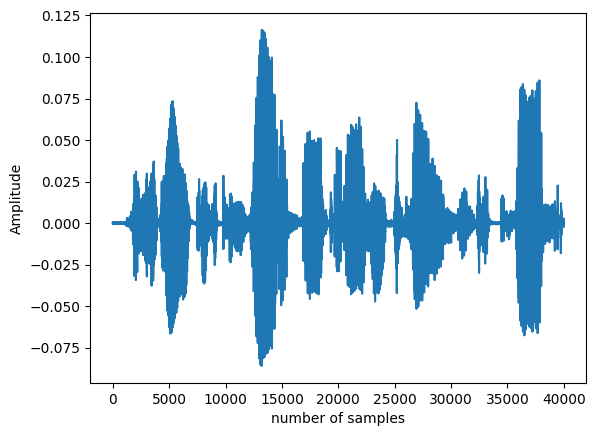

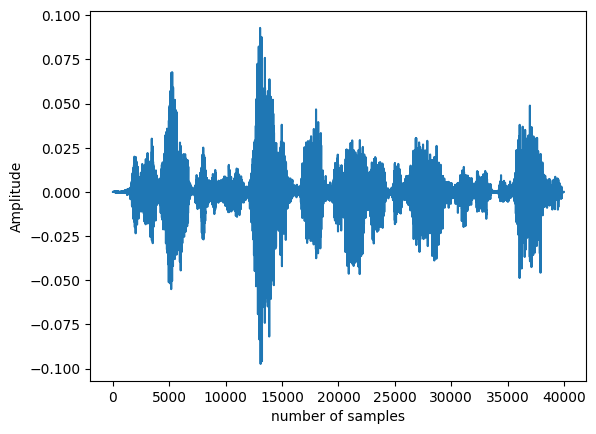

In [72]:
   
audioIn, fs = lb.load('audio.wav', sr=None)   # read audio


wLen = int(0.032*fs)                   # window length
winAn_sqrt = scipy.signal.windows.hann(wLen, sym=False) # analysis window  
winAn = np.sqrt(winAn_sqrt) # analysis window
winSyn = winAn



winHopAn = int(0.008*fs)             # Hop length or frame advance
inInd = 0

R = 1.4 #winHopSyn / winHopAn
Phase_previous = 0
Phase_synthesis = 0

audioOut = np.zeros(int(len(audioIn)))      # placeholder for reconstructed audio

while inInd< len(audioIn)-wLen:
    # selct the frame and multiply with window function
    frame = audioIn[inInd:inInd+wLen]* winAn 

    # compute DFT
    f = fft(frame)

    # save magnitudes and phases
    mag_f = np.abs(f)
    phi0 = np.angle(f) 

    ####################
    # processing in spectral domain 
    #######################

    # Phase difference unwrapping
    Phase_current = phi0
    delta_phi = delta_phi_(Phase_current, Phase_previous, winHopAn, wLen)

    # Phase sysnthesis
    Phase_previous = Phase_current
    synthesis_phase = Phase_previous + R*delta_phi
    # This phase is used for synthesis, adjust the phase difference between consecutive frames

    #Synthesis phase using princarg
    phi0 = princarg(synthesis_phase)
    Phase_synthesis = phi0

    
    # Recover the complex FFT back
    ft = (abs(f)* np.exp(1j*phi0))  

    # inverse DFT and windowing
    frame = np.real(ifft(ft))*winSyn

    # Ovelap add
    audioOut[inInd :inInd +wLen] =  audioOut[inInd :inInd +wLen] + frame

    # frame advance by winHopAn
    inInd = inInd + int(winHopAn*R)
    
plt.plot(audioIn[int(0.0*fs):int(5*fs)])
plt.ylabel("Amplitude")
plt.xlabel("number of samples")
plt.show()

plt.plot(audioOut[int(0.0*fs):int(5*fs)])
plt.ylabel("Amplitude")
plt.xlabel("number of samples")
plt.show()


In [73]:
sd.play(audioIn, fs)

In [74]:
sd.play(audioOut, fs)

### Bonus question: Add pitch shifting